In [1]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import emoji
import Preprocessing as preproc
import nltk
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

c:\Users\wojci\anaconda3\envs\text-mining1\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wojci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wojci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wojci\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\wojci\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [2]:
import pickle

with open('data_hyderabad/data_preprocessed_classification.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

In [3]:
loaded_data.head(3)

,Restaurant,Review,Review_Preprocessed,Cuisines,meals
0,Beyond Flavours,"The ambience was good, food was quite good . h...","[(ambience, NN), (good, JJ), (food, NN), (quit...","Chinese, Continental, Kebab, European, South I...",[]
1,Beyond Flavours,Ambience is too good for a pleasant evening. S...,"[(ambience, NN), (good, JJ), (pleasant, JJ), (...","Chinese, Continental, Kebab, European, South I...",[]
2,Beyond Flavours,A must try.. great food great ambience. Thnx f...,"[(must, MD), (try, VB), (great, JJ), (food, NN...","Chinese, Continental, Kebab, European, South I...",[Penne Alfredo Pasta]


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

def split_list_into_onehot_labels(dataframe, column_name):
    """
    Splits a list of comma-separated values in a specified column of a DataFrame into one-hot encoded labels.
    Args:
        dataframe (pd.DataFrame): The input DataFrame containing the data.
        column_name (str): The name of the column containing comma-separated values to be one-hot encoded.
    Returns:
        pd.DataFrame: The DataFrame with the original column split into a single column containing one-hot encoded vectors.

    """
    mlb = MultiLabelBinarizer()
    dataframe[column_name] = dataframe[column_name].apply(lambda x: x.split(", "))

    cuisine_encoded = mlb.fit_transform(dataframe[column_name])

    dataframe['Cuisine_Vector'] = list(cuisine_encoded)
    return dataframe, mlb

data_joined, mlb = split_list_into_onehot_labels(loaded_data, 'Cuisines')

In [5]:
data_joined.head(3)

,Restaurant,Review,Review_Preprocessed,Cuisines,meals,Cuisine_Vector
0,Beyond Flavours,"The ambience was good, food was quite good . h...","[(ambience, NN), (good, JJ), (food, NN), (quit...","[Chinese, Continental, Kebab, European, South ...",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ..."
1,Beyond Flavours,Ambience is too good for a pleasant evening. S...,"[(ambience, NN), (good, JJ), (pleasant, JJ), (...","[Chinese, Continental, Kebab, European, South ...",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ..."
2,Beyond Flavours,A must try.. great food great ambience. Thnx f...,"[(must, MD), (try, VB), (great, JJ), (food, NN...","[Chinese, Continental, Kebab, European, South ...",[Penne Alfredo Pasta],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ..."


In [8]:
import spacy
nlp = spacy.load("en_core_web_sm")

def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_.lower() for token in doc]

def transform_and_group_dataframe(df):
    
    df = df[df['meals'].apply(lambda x: len(x) > 0)]  # drop the rows where there were no meals mentioned

    df['Review_Preprocessed_No_Pos'] = df['Review_Preprocessed'].apply(lambda x: [token for token, pos in x])  # extract token from the tuple

    # Lemmatize the text
    df["Review_Preprocessed_No_Pos"] = df['Review_Preprocessed_No_Pos'].apply(lemmatize_tokens)
    df["meals"] = df['meals'].apply(lemmatize_tokens)

    data_per_row = df.reset_index(drop=True)

    # Grouping
    cuisine_df = df[['Restaurant','Cuisine_Vector']]

    df = df.groupby('Restaurant').agg({
        'Review': lambda x: [', '.join(x)],
        'Review_Preprocessed_No_Pos': lambda x: [', '.join([', '.join(tokens) for tokens in x])],
        'Review_Preprocessed': lambda x: [', '.join([', '.join([f"({token}, {pos})" for token, pos in tokens]) for tokens in x])],
        'meals': lambda x: [', '.join([meal for sublist in x for meal in sublist])]
    }).reset_index()

    df = df.merge(cuisine_df, on='Restaurant', how='left')
    df.drop_duplicates(subset='Restaurant', inplace=True)
    df.reset_index(drop=True, inplace=True)

    data_grouped = df

    return data_grouped, data_per_row

# Runs for 4 minutes
data_grouped, data_per_row = transform_and_group_dataframe(data_joined)

meals zostaly podzielone po spacji

In [9]:
data_per_row.head(3)

,Restaurant,Review,Review_Preprocessed,Cuisines,meals,Cuisine_Vector,Review_Preprocessed_No_Pos
0,Beyond Flavours,A must try.. great food great ambience. Thnx f...,"[(must, MD), (try, VB), (great, JJ), (food, NN...","[Chinese, Continental, Kebab, European, South ...","[penne, alfredo, pasta]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[must, try, great, food, great, ambience, thnx..."
1,Beyond Flavours,Food is good. we ordered Kodi drumsticks and b...,"[(food, NN), (good, JJ), (ordered, VBD), (kodi...","[Chinese, Continental, Kebab, European, South ...","[kodi, drumstick, basket, mutton, biryani]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[food, good, order, kodi, drumstick, basket, m..."
2,Beyond Flavours,Well after reading so many reviews finally vis...,"[(well, RB), (reading, VBG), (many, JJ), (revi...","[Chinese, Continental, Kebab, European, South ...","[corn, tawa, fish, basket, biryani, biryani]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[well, read, many, review, finally, visit, amb..."


In [10]:
data_grouped.head(3)

,Restaurant,Review,Review_Preprocessed_No_Pos,Review_Preprocessed,meals,Cuisine_Vector
0,10 Downing Street,[I've been to this place about two times and i...,"[place, two, time, really, like, ambience, int...","[(place, NN), (two, CD), (times, NNS), (really...","[lasagna, veg, platter, lasagna, roll, beer, v...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
1,13 Dhaba,[I didn't go and eat at the Dhaba. I had order...,"[go, eat, dhaba, order, taste, amazing, te, is...","[(go, VB), (eat, VB), (dhaba, NNP), (ordered, ...","[lassi, chole, bhature, lassi, chole, bhature,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"3B's - Buddies, Bar & Barbecue",[Gobind Passionate in serving Polite in nature...,"[gobind, passionate, serve, polite, nature, st...","[(gobind, NNP), (passionate, NNP), (serving, V...","[polite, pan, ice, cream, pan, ice, cream, pan...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


# **Vectorizaton**

Word2Vec

In [11]:
from gensim.models import Word2Vec

def train_word2vec_and_generate_vectors(dataframe, column_name, vector_size=100, window=5, min_count=1, workers=4, sg=1):
    """
    Trains a Word2Vec model on the specified column of the dataframe and generates vectors for each entry.
    
    Returns:
        pd.DataFrame: The DataFrame with a new column containing the Word2Vec vectors.
    """
    # Train the Word2Vec model on the specified column
    model = Word2Vec(
        sentences=dataframe[column_name].tolist(),
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=sg
    )

    # Generate vectors for each entry
    def get_vector(entry):
        words = entry
        vector = sum(model.wv[word] for word in words if word in model.wv)
        return vector / len(words) if words else [0] * vector_size

    # Apply the function to each entry and create a new column
    dataframe[f'{column_name}_Word2Vec_Vector'] = dataframe[column_name].apply(get_vector)
    
    return dataframe

# Apply the function to the 'Review_Preprocessed_No_Pos' column
data_per_row = train_word2vec_and_generate_vectors(data_per_row, 'Review_Preprocessed_No_Pos')
data_per_row = train_word2vec_and_generate_vectors(data_per_row, 'meals')

data_grouped = train_word2vec_and_generate_vectors(data_grouped, 'Review_Preprocessed_No_Pos')
data_grouped = train_word2vec_and_generate_vectors(data_grouped, 'meals')

Count Vectorizer

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

def create_count_vectorizer_vector(df, column):
  """
  Creates a CountVectorizer vector for each row in the specified column of the dataframe.
  
  Args:
    df (pd.DataFrame): The input DataFrame containing the data.
    column (str): The name of the column to be vectorized.
  
  Returns:
    pd.DataFrame: The DataFrame with a new column containing the CountVectorizer vectors.
  """
  # Create a CountVectorizer object
  vectorizer = CountVectorizer()

  # Fit the vectorizer on the entire column
  vectorizer.fit([item for sublist in df[column] for item in sublist])

  # Transform each row individually
  def transform_row(row):
    row_str = " ".join(row)  # Convert list to string
    X = vectorizer.transform([row_str])
    return X.toarray()[0]

  # Apply the function to each row and create a new column
  df[f'{column}_Count_Vector'] = df[column].apply(transform_row)

  return df

data_per_row = create_count_vectorizer_vector(data_per_row, 'meals')
data_per_row = create_count_vectorizer_vector(data_per_row, 'Review_Preprocessed_No_Pos')

data_grouped = create_count_vectorizer_vector(data_grouped, 'meals')
data_grouped = create_count_vectorizer_vector(data_grouped, 'Review_Preprocessed_No_Pos')

TF-IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorize(df, column):
    """
    Creates a TF-IDF vector for each row in the specified column of the dataframe.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        column (str): The name of the column to be vectorized.
    
    Returns:
        pd.DataFrame: The DataFrame with a new column containing the TF-IDF vectors.
    """
    # Create a TF-IDF vectorizer object
    vectorizer = TfidfVectorizer()

    # Fit the vectorizer on the entire column
    vectorizer.fit([item for sublist in df[column] for item in sublist])

    # Transform each row individually
    def transform_row(row):
        row_str = " ".join(row)  # Convert list to string
        X = vectorizer.transform([row_str])
        return X.toarray()[0]

    # Apply the function to each row and create a new column
    df[f'{column}_TFIDF_Vector'] = df[column].apply(transform_row)

    return df

data_grouped = tfidf_vectorize(data_grouped, 'meals')
data_grouped = tfidf_vectorize(data_grouped, 'Review_Preprocessed_No_Pos')

data_per_row = tfidf_vectorize(data_per_row, 'meals')
data_per_row = tfidf_vectorize(data_per_row, 'Review_Preprocessed_No_Pos')

In [14]:
data_per_row.head(5)

,Restaurant,Review,Review_Preprocessed,Cuisines,meals,Cuisine_Vector,Review_Preprocessed_No_Pos,Review_Preprocessed_No_Pos_Word2Vec_Vector,meals_Word2Vec_Vector,meals_Count_Vector,Review_Preprocessed_No_Pos_Count_Vector,meals_TFIDF_Vector,Review_Preprocessed_No_Pos_TFIDF_Vector
0,Beyond Flavours,A must try.. great food great ambience. Thnx f...,"[(must, MD), (try, VB), (great, JJ), (food, NN...","[Chinese, Continental, Kebab, European, South ...","[penne, alfredo, pasta]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[must, try, great, food, great, ambience, thnx...","[0.13795842, 0.33386505, 0.18234783, -0.136860...","[-0.0026127577, 0.17256455, 0.19126916, 0.0642...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Beyond Flavours,Food is good. we ordered Kodi drumsticks and b...,"[(food, NN), (good, JJ), (ordered, VBD), (kodi...","[Chinese, Continental, Kebab, European, South ...","[kodi, drumstick, basket, mutton, biryani]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[food, good, order, kodi, drumstick, basket, m...","[-0.01796363, 0.29096505, 0.3056821, 0.0032824...","[-0.18095131, 0.12073517, 0.09533099, -0.07110...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Beyond Flavours,Well after reading so many reviews finally vis...,"[(well, RB), (reading, VBG), (many, JJ), (revi...","[Chinese, Continental, Kebab, European, South ...","[corn, tawa, fish, basket, biryani, biryani]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[well, read, many, review, finally, visit, amb...","[0.036612976, 0.28236088, 0.24257526, -0.04772...","[-0.16195488, 0.114763856, 0.15531987, -0.0801...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Beyond Flavours,Came for the birthday treat of a close friend....,"[(came, NN), (birthday, JJ), (treat, NN), (clo...","[Chinese, Continental, Kebab, European, South ...","[chili, honey, lotus, stem]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[come, birthday, treat, close, friend, perfect...","[0.079275884, 0.28089848, 0.16606173, -0.10248...","[-0.11484219, 0.12794568, 0.16795075, -0.04010...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Beyond Flavours,Food was very good. Soup was as expected. In s...,"[(food, NN), (good, JJ), (soup, NNP), (expecte...","[Chinese, Continental, Kebab, European, South ...","[soup, honey, chilli, lotus]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, ...","[food, good, soup, expect, starter, order, hon...","[0.064236075, 0.25492215, 0.25263238, 0.015005...","[-0.14708978, 0.10693014, 0.20456752, 0.035838...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# **Modelling**

# **Modelling without data leakage**

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
data_per_row_train, data_per_row_test = train_test_split(data_per_row, test_size=0.2, random_state=42, shuffle=True)
data_grouped_train, data_grouped_test = train_test_split(data_grouped, test_size=0.2, random_state=42, shuffle=True)

In [16]:
from gensim.models import Word2Vec

def train_word2vec_and_generate_vectors(dataframe_train, dataframe_test, column_name, vector_size=100, window=5, min_count=1, workers=4, sg=1):
    """
    Trains a Word2Vec model on the specified column of the training dataframe and generates vectors for both train and test data.

    Returns:
        pd.DataFrame: The DataFrame with a new column containing the Word2Vec vectors.
    """

    # Train the Word2Vec model on the training data
    model = Word2Vec(
        sentences=dataframe_train[column_name].tolist(),
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=sg
    )

    # Function to generate vectors for a given sentence
    def get_vector(entry):
        words = entry
        vectors = []
        for word in words:
            if word in model.wv:
                vectors.append(model.wv[word])
            else:
                # 2. Zero Vector:
                 vectors.append(np.zeros(vector_size))
        if vectors:
            return np.sum(vectors, axis=0)
        else:
            return np.zeros(vector_size)

    # Apply the function to both train and test dataframes
    dataframe_train[f'{column_name}_Word2Vec_Vector'] = dataframe_train[column_name].apply(get_vector)
    dataframe_test[f'{column_name}_Word2Vec_Vector'] = dataframe_test[column_name].apply(get_vector)

    return dataframe_train, dataframe_test

# Apply the function to the 'Review_Preprocessed_No_Pos' column
data_per_row_train, data_per_row_test = train_word2vec_and_generate_vectors(data_per_row_train, data_per_row_test, 'Review_Preprocessed_No_Pos')
data_per_row_train, data_per_row_test = train_word2vec_and_generate_vectors(data_per_row_train, data_per_row_test, 'meals')

data_grouped_train, data_grouped_test = train_word2vec_and_generate_vectors(data_grouped_train, data_grouped_test, 'Review_Preprocessed_No_Pos')
data_grouped_train, data_grouped_test = train_word2vec_and_generate_vectors(data_grouped_train, data_grouped_test, 'meals')

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

def create_count_vectorizer_vector(dataframe_train, dataframe_test, column):
    """
    Creates a CountVectorizer vector for each row in the specified column of the training and testing dataframes.
    
    Args:
        dataframe_train (pd.DataFrame): The training DataFrame containing the data.
        dataframe_test (pd.DataFrame): The testing DataFrame containing the data.
        column (str): The name of the column to be vectorized.
    
    Returns:
        pd.DataFrame, pd.DataFrame: The training and testing DataFrames with new columns containing the CountVectorizer vectors.
    """
    # Create a CountVectorizer object
    vectorizer = CountVectorizer()

    # Fit the vectorizer on the entire column of the training dataframe
    vectorizer.fit([item for sublist in dataframe_train[column] for item in sublist])

    # Transform each row individually for the training dataframe
    def transform_row(row):
        row_str = " ".join(row)  # Convert list to string
        X = vectorizer.transform([row_str])
        return X.toarray()[0]

    # Apply the function to each row and create a new column for the training dataframe
    dataframe_train[f'{column}_Count_Vector'] = dataframe_train[column].apply(transform_row)
    # Apply the function to each row and create a new column for the testing dataframe
    dataframe_test[f'{column}_Count_Vector'] = dataframe_test[column].apply(transform_row)

    return dataframe_train, dataframe_test

data_per_row_train, data_per_row_test = create_count_vectorizer_vector(data_per_row_train, data_per_row_test, 'Review_Preprocessed_No_Pos')
data_per_row_train, data_per_row_test = create_count_vectorizer_vector(data_per_row_train, data_per_row_test, 'meals')

data_grouped_train, data_grouped_test = create_count_vectorizer_vector(data_grouped_train, data_grouped_test, 'Review_Preprocessed_No_Pos')
data_grouped_train, data_grouped_test = create_count_vectorizer_vector(data_grouped_train, data_grouped_test, 'meals')

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorize(dataframe_train, dataframe_test, column):
    """
    Creates a TF-IDF vector for each row in the specified column of the dataframe.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
        column (str): The name of the column to be vectorized.
    
    Returns:
        pd.DataFrame: The DataFrame with a new column containing the TF-IDF vectors.
    """
    # Create a TF-IDF vectorizer object
    vectorizer = TfidfVectorizer()

    # Fit the vectorizer on the entire column
    vectorizer.fit([item for sublist in dataframe_train[column] for item in sublist])

    # Transform each row individually
    def transform_row(row):
        row_str = " ".join(row)  # Convert list to string
        X = vectorizer.transform([row_str])
        return X.toarray()[0]

    # Apply the function to each row and create a new column
    dataframe_train[f'{column}_TFIDF_Vector'] = dataframe_train[column].apply(transform_row)
    dataframe_test[f'{column}_TFIDF_Vector'] = dataframe_test[column].apply(transform_row)


    return dataframe_train, dataframe_test

data_per_row_train, data_per_row_test = tfidf_vectorize(data_per_row_train, data_per_row_test, 'Review_Preprocessed_No_Pos')
data_per_row_train, data_per_row_test = tfidf_vectorize(data_per_row_train, data_per_row_test, 'meals')

data_grouped_train, data_grouped_test = tfidf_vectorize(data_grouped_train, data_grouped_test, 'Review_Preprocessed_No_Pos')
data_grouped_train, data_grouped_test = tfidf_vectorize(data_grouped_train, data_grouped_test, 'meals')

In [19]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multioutput import ClassifierChain, MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from tqdm import tqdm
from sklearn.metrics import classification_report
from joblib import Parallel, delayed


def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model and return metrics"""
    report = classification_report(y_true, y_pred, output_dict=True)
    return {
        'model': model_name,
        'weighted_f1': report['weighted avg']['f1-score'],
        'macro_f1': report['macro avg']['f1-score']
    }

def evaluate_single_model(feature_col, base_model, wrapper, df_type, train_df, test_df, target_col):
    try:
        # Prepare data
        X_train = np.vstack(train_df[feature_col].values)
        X_test = np.vstack(test_df[feature_col].values)
        y_train = np.array(train_df[target_col].tolist())
        y_test = np.array(test_df[target_col].tolist())
        
        # Quick check for class distribution
        #if len(np.unique(y_train)) < 2:
        #    return None
        
        # Create and train model
        model = wrapper(base_model)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Evaluate
        eval_result = evaluate_model(y_test, y_pred, f"{wrapper.__name__}_{base_model.__class__.__name__}_{feature_col}")
        eval_result['feature_col'] = feature_col
        eval_result['df_type'] = df_type
        return eval_result
        
    except Exception as e:
        print(f"Error with {wrapper.__name__}_{base_model.__class__.__name__}_{feature_col} on {df_type}: {str(e)}")
        return None

def train_evaluate_models(df_train_per_row, df_test_per_row, 
                         df_train_grouped, df_test_grouped, 
                         feature_cols, target_col, n_jobs=-1):
    """Parallel training and evaluation of models"""
    
    # Define base models - initialize once
    base_models = {
        'LogisticRegression': LogisticRegression(solver='lbfgs', random_state=0, class_weight="balanced", max_iter=1000),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=0),
        'LinearSVC': LinearSVC(random_state=0, max_iter=2000)
    }
    
    # Define wrapper models
    wrappers = {
        'ClassifierChain': ClassifierChain,
        'OneVsRest': OneVsRestClassifier,
        'MultiOutput': MultiOutputClassifier
    }
    
    # Define DataFrame types
    df_types = {
        'per_row': (df_train_per_row, df_test_per_row),
        'grouped': (df_train_grouped, df_test_grouped)
    }
    
    # Create all combinations
    combinations = [
        (feature_col, base_model, wrapper, df_type, train_df, test_df)
        for feature_col in feature_cols
        for base_model in base_models.values()
        for wrapper in wrappers.values()
        for df_type, (train_df, test_df) in df_types.items()
    ]
    
    # Run parallel evaluation
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_single_model)(
            feature_col, base_model, wrapper, df_type, train_df, test_df, target_col
        )
        for feature_col, base_model, wrapper, df_type, train_df, test_df in tqdm(combinations)
    )
    
    # Filter None results and convert to DataFrame
    results = [r for r in results if r is not None]
    return pd.DataFrame(results)

feature_columns = [
    'meals_Word2Vec_Vector',
    'Review_Preprocessed_No_Pos_Word2Vec_Vector',

    'meals_Count_Vector',    
    'Review_Preprocessed_No_Pos_Count_Vector',

    'meals_TFIDF_Vector',    
    'Review_Preprocessed_No_Pos_TFIDF_Vector'
]

# Usage remains the same
results = train_evaluate_models(
    df_train_per_row=data_per_row_train,
    df_test_per_row=data_per_row_test,
    df_train_grouped=data_grouped_train,
    df_test_grouped=data_grouped_test,
    feature_cols=feature_columns,
    target_col='Cuisine_Vector'
)

100%|██████████| 108/108 [26:55<00:00, 14.96s/it]


In [20]:
# If called again, pleases change the name of the file 

#results.to_csv('data_hyderabad/all_model_results.csv', index=False)

In [21]:
results.sort_values(['macro_f1'], ascending=[False])

,model,weighted_f1,macro_f1,feature_col,df_type
73,MultiOutputClassifier_LogisticRegression_Revie...,0.610538,0.492882,Review_Preprocessed_No_Pos_TFIDF_Vector,per_row
71,OneVsRestClassifier_LogisticRegression_Review_...,0.610538,0.492882,Review_Preprocessed_No_Pos_TFIDF_Vector,per_row
43,OneVsRestClassifier_LogisticRegression_Review_...,0.608301,0.477934,Review_Preprocessed_No_Pos_Count_Vector,per_row
45,MultiOutputClassifier_LogisticRegression_Revie...,0.608301,0.477934,Review_Preprocessed_No_Pos_Count_Vector,per_row
80,ClassifierChain_LinearSVC_Review_Preprocessed_...,0.605337,0.476202,Review_Preprocessed_No_Pos_TFIDF_Vector,per_row
...,...,...,...,...,...
16,OneVsRestClassifier_LogisticRegression_Review_...,0.101010,0.015873,Review_Preprocessed_No_Pos_Word2Vec_Vector,grouped
19,ClassifierChain_RandomForestClassifier_Review_...,0.101010,0.015873,Review_Preprocessed_No_Pos_Word2Vec_Vector,grouped
7,OneVsRestClassifier_RandomForestClassifier_mea...,0.101010,0.015873,meals_Word2Vec_Vector,grouped
21,OneVsRestClassifier_RandomForestClassifier_Rev...,0.101010,0.015873,Review_Preprocessed_No_Pos_Word2Vec_Vector,grouped


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

X_train = np.vstack(data_per_row_train["Review_Preprocessed_No_Pos_TFIDF_Vector"].values)
X_test = np.vstack(data_per_row_test["Review_Preprocessed_No_Pos_TFIDF_Vector"].values)
y_train = np.array(data_per_row_train["Cuisine_Vector"].tolist())
y_test = np.array(data_per_row_test["Cuisine_Vector"].tolist())

moc = MultiOutputClassifier(LogisticRegression(solver='lbfgs', random_state=0, class_weight="balanced")).fit(X_train, y_train)
y_pred = moc.predict(X_test)

report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

predicted_labels_df = report_df.loc[mlb.classes_, ['f1-score']].reset_index()
predicted_labels_df.columns = ['Label', 'F1-Score']
predicted_labels_df = predicted_labels_df.sort_values('F1-Score', ascending=False)
predicted_labels_df

,Label,F1-Score
32,North Indian,0.829157
25,Lebanese,0.722222
31,North Eastern,0.720000
12,Desserts,0.706173
19,Ice Cream,0.705882
17,Healthy Food,0.700000
10,Chinese,0.693750
33,Pizza,0.666667
5,Bakery,0.652632
11,Continental,0.640708


In [33]:
report_normal = classification_report(y_test, y_pred, target_names=mlb.classes_)
print(report_normal)

               precision    recall  f1-score   support

     American       0.51      0.69      0.59        75
       Andhra       0.31      0.60      0.41        68
      Arabian       0.23      0.54      0.32        26
        Asian       0.44      0.74      0.55       151
          BBQ       0.42      0.70      0.52        23
       Bakery       0.58      0.74      0.65        84
    Beverages       0.49      0.63      0.55        75
      Biryani       0.53      0.63      0.58       189
       Burger       0.55      0.69      0.61        62
         Cafe       0.51      0.73      0.60        96
      Chinese       0.65      0.74      0.69       447
  Continental       0.57      0.73      0.64       248
     Desserts       0.68      0.73      0.71       195
     European       0.39      0.63      0.48        41
    Fast Food       0.57      0.73      0.64       159
  Finger Food       0.17      0.50      0.26        16
         Goan       0.47      0.50      0.48        14
 Healthy 

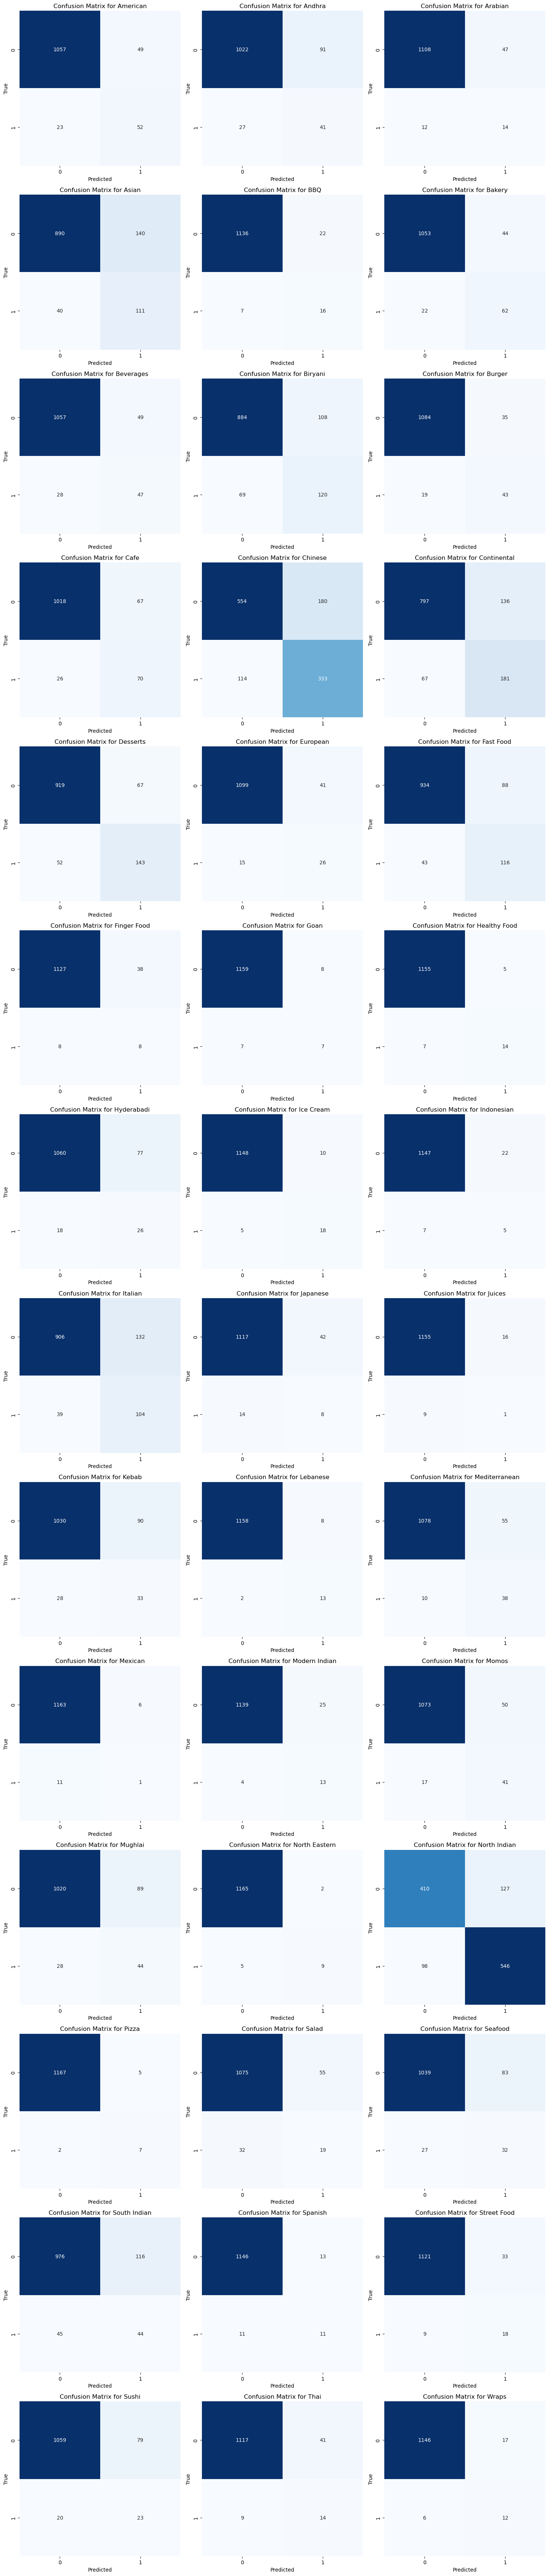

In [24]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Assuming y_test, y_pred, and mlb.classes_ are already defined
# Calculate confusion matrix for each label
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Dynamic grid setup
n_labels = len(mlb.classes_)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_labels / n_cols)  # Calculate required rows

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 5))  # Adjust figure size
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot confusion matrices for each label
for i, (label, conf_matrix) in enumerate(zip(mlb.classes_, conf_matrices)):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False, annot_kws={"size": 10})
    axes[i].set_title(f'Confusion Matrix for {label}', fontsize=12)
    axes[i].set_xlabel('Predicted', fontsize=10)
    axes[i].set_ylabel('True', fontsize=10)

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')  # Turn off empty subplots

plt.tight_layout()  # Adjust spacing
plt.show()
